# Analiza prometnih nesreč v Sloveniji

In [104]:
import pandas as pd
from pyproj import Transformer

years = range(2014, 2024)
dataFrames = []

for year in years:
    dataFrame = pd.read_csv(f"./data/pn{year}.csv", encoding="cp1250", delimiter=";")
    dataFrame["Year"] = year
    dataFrames.append(dataFrame)
    
#Vse v en dataframe (lažje iskanje)
data = pd.concat(dataFrames, ignore_index=True)

#Spremenimo , v . in kjer je NAN damo na 0
alko_raw = data["VrednostAlkotesta"].astype(str).str.replace(",", ".").str.strip()
alko = pd.to_numeric(alko_raw, errors="coerce").fillna(0)

#Spremenim x in y v lat in lon

data["x"] = pd.to_numeric(data["GeoKoordinataX"], errors="coerce")
data["y"] = pd.to_numeric(data["GeoKoordinataY"], errors="coerce")
data = data.dropna(subset=["x", "y"])

transformer = Transformer.from_crs("EPSG:3912", "EPSG:4326", always_xy=True)

lons, lats  = transformer.transform(data["y"].values, data["x"].values)

data["lon"] = lons
data["lat"] = lats

## Klasifikacija nesreč

Na spodnjem stolpčnem diagramu smo prikazali število prometnih nesreč v Sloveniji v letu 2023, razvrščenih glede na njihovo klasifikacijo. Podatki so razdeljeni v več kategorij, med katerimi prevladujejo nesreče z materialno škodo.

Ta vrsta nesreče predstavlja daleč največji delež vseh obravnavanih primerov, kar kaže na to, da so najpogostejše situacije, kjer ne pride do telesnih poškodb, temveč zgolj do škode na vozilih ali infrastrukturi.

Alkohol


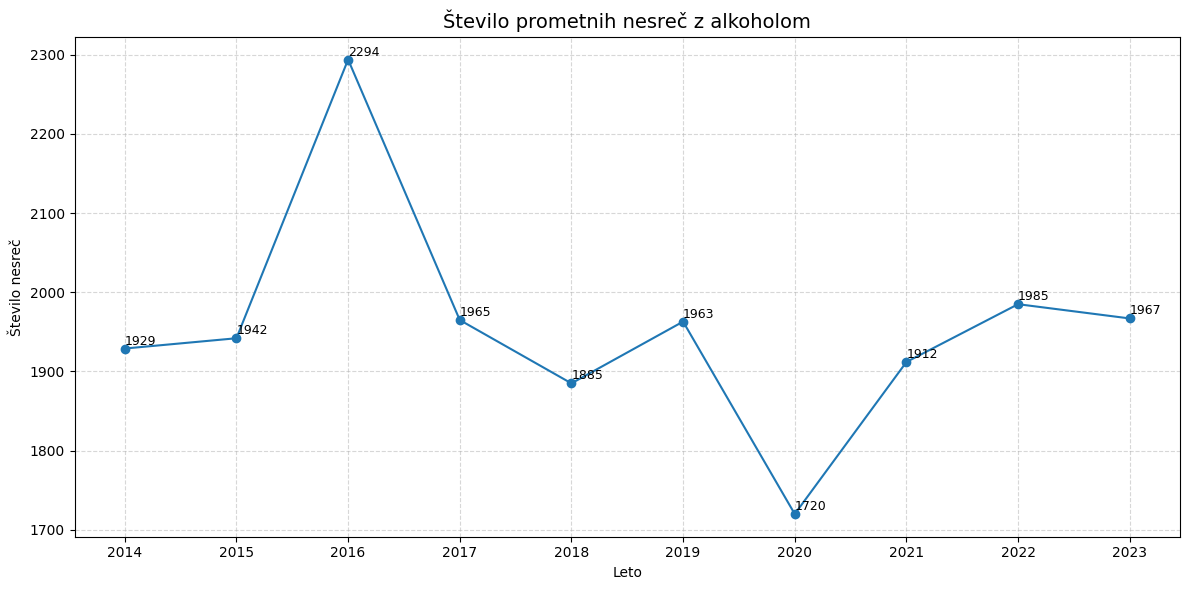

In [78]:
import matplotlib.pyplot as plt

alko_present = alko > 0
data["AlkoholPrisoten"] = alko_present

yearly_stats = data.groupby("Year").agg(
    Skupaj=("AlkoholPrisoten", "count"),
    ZAlkoholom=("AlkoholPrisoten", "sum")
)
yearly_stats["Odstotek"] = (yearly_stats["ZAlkoholom"] / yearly_stats["Skupaj"]) * 100

plt.figure(figsize=(12, 6))
plt.plot(yearly_stats.index, yearly_stats["ZAlkoholom"], marker="o")
for year, value in yearly_stats["ZAlkoholom"].items():
    plt.text(year, value + 5, value, fontsize=9)
plt.title("Število prometnih nesreč z alkoholom", fontsize=14)
plt.xlabel("Leto")
plt.ylabel("Število nesreč")
plt.xticks(yearly_stats.index)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


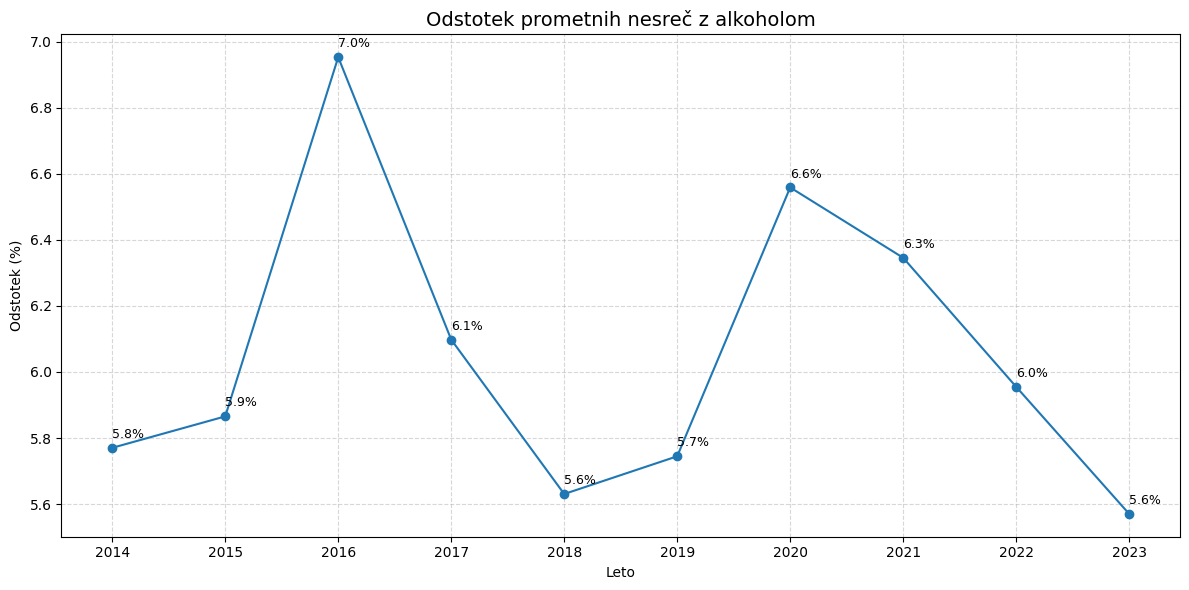

In [79]:
plt.figure(figsize=(12, 6))
plt.plot(yearly_stats.index, yearly_stats["Odstotek"], marker="o")
for year, value in yearly_stats["Odstotek"].items():
    plt.text(year, value + 0.03, f"{value:.1f}%", fontsize=9)
plt.title("Odstotek prometnih nesreč z alkoholom", fontsize=14)
plt.xlabel("Leto")
plt.ylabel("Odstotek (%)")
plt.xticks(yearly_stats.index)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Število nesreč z opravljenim alkotestom: 19562
Pod 0.24 mg/l: 4643 (23.73%)
Nad 0.24 mg/l (prekršek): 14919 (76.27%)


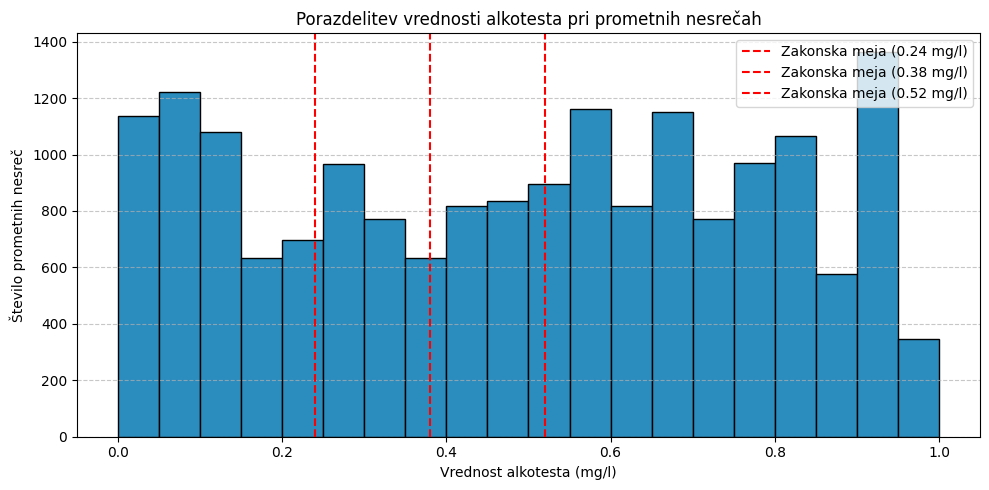

In [80]:
import matplotlib.pyplot as plt

alko_values = alko[alko > 0]

pod_mejo = (alko_values < 0.24).sum()
nad_mejo = (alko_values >= 0.24).sum()
skupaj = pod_mejo + nad_mejo

print(f"Število nesreč z opravljenim alkotestom: {skupaj}")
print(f"Pod 0.24 mg/l: {pod_mejo} ({pod_mejo / skupaj:.2%})")
print(f"Nad 0.24 mg/l (prekršek): {nad_mejo} ({nad_mejo / skupaj:.2%})")

bins = [i * 0.05 for i in range(0, 21)]

plt.figure(figsize=(10, 5))
plt.hist(alko_values, bins=bins, edgecolor='black', color="#2b8cbe")
plt.axvline(0.24, color='red', linestyle='--', label='Zakonska meja (0.24 mg/l)')
plt.axvline(0.38, color='red', linestyle='--', label='Zakonska meja (0.38 mg/l)')
plt.axvline(0.52, color='red', linestyle='--', label='Zakonska meja (0.52 mg/l)')

plt.xlabel("Vrednost alkotesta (mg/l)")
plt.ylabel("Število prometnih nesreč")
plt.title("Porazdelitev vrednosti alkotesta pri prometnih nesrečah")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


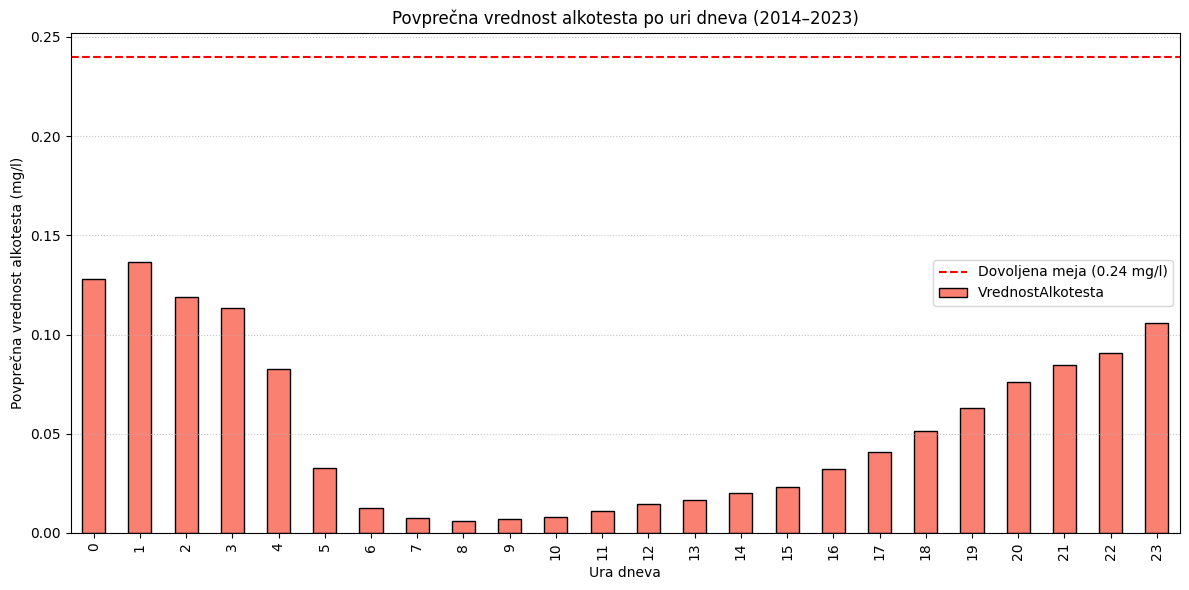

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

alko_data = data.copy()
alko_data["VrednostAlkotesta"] = pd.to_numeric(
    alko_data["VrednostAlkotesta"].astype(str).str.replace(",", ".").str.strip(), 
    errors="coerce"
)
alko_data = alko_data.dropna(subset=["VrednostAlkotesta"])
alko_data = alko_data[alko_data["VrednostAlkotesta"] >= 0]

alko_data["UraPN"] = alko_data["UraPN"].astype(str).str.replace(",", ".").str.strip()
alko_data = alko_data[alko_data["UraPN"].str.match(r"^\d+(\.\d+)?$")]  # odstrani čudne vrednosti
alko_data["UraPN"] = alko_data["UraPN"].astype(float).astype(int)


avg_by_hour = alko_data.groupby("UraPN")["VrednostAlkotesta"].mean()

plt.figure(figsize=(12, 6))
avg_by_hour.plot(kind="bar", color="salmon", edgecolor="black")
plt.axhline(y=0.24, color="red", linestyle="--", label="Dovoljena meja (0.24 mg/l)")
plt.xlabel("Ura dneva")
plt.ylabel("Povprečna vrednost alkotesta (mg/l)")
plt.title("Povprečna vrednost alkotesta po uri dneva (2014–2023)")
plt.legend()
plt.grid(axis="y", linestyle=":", alpha=0.7)
plt.tight_layout()
plt.show()


# Zemljevid

In [ ]:
import pandas as pd
from shapely.geometry import shape, Point
import json

with open("./data/si.json", "r", encoding="utf-8") as f:
    slovenia_map = json.load(f)

data_2023 = data[data["Year"] == 2023]


C:\Users\Tilen\AppData\Local\Temp\ipykernel_3560\1308803613.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Tilen\AppData\Local\Temp\ipykernel_3560\1308803613.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [105]:
data_2023 = data_2023.head(1000)
obcine = []
for idx, row in data_2023.iterrows():
    point = Point(row["lon"], row["lat"])

    found = None
    for feature in slovenia_map["features"]:
        polygon = shape(feature["geometry"])
        if polygon.contains(point):
            found = feature["properties"].get("name", "Neznano")
            break

    obcine.append(found)

data_2023["Obcina"] = obcine


In [106]:
import numpy as np
import geopandas as gpd
import plotly.express as px

accident_counts = data_2023.groupby("Obcina").size().reset_index(name="accidents")

slovenia_map = gpd.read_file("./data/si.json")
slovenia_map = slovenia_map.merge(accident_counts, left_on="name", right_on="Obcina", how="left")
slovenia_map["accidents"] = slovenia_map["accidents"].fillna(0)

slovenia_map["log_accidents"] = np.log1p(slovenia_map["accidents"]) 

fig = px.choropleth_map(
    slovenia_map,
    geojson=slovenia_map.geometry,
    locations=slovenia_map.index,
    color="log_accidents",
    color_continuous_scale="Reds",
    zoom=7,
    center={"lat": 46.0, "lon": 14.5},
    opacity=0.6,
    hover_data={
        "name": True,
        "accidents": True,
        "log_accidents": False
    },
    labels={"accidents": "Število nesreč"},
    title="Prometne nesreče po občinah (2023)",
    height=800
)

fig.show()


In [108]:
fig = px.scatter_map(
    data_2023,
    lat="lat",
    lon="lon",
    hover_name="OpisKraja",
    color_discrete_sequence=["red"],
    zoom=7,
    center={"lat": 46.0, "lon": 14.5},
    height=800,
    title="Prometne nesreče v letu 2023 (lokacije)"
)

fig.update_layout(map_style="open-street-map")
fig.show()


In [109]:
smrtne = data[data["KlasifikacijaNesrece"] == "S SMRTNIM IZIDOM"]

fig = px.scatter_map(
    smrtne,
    lat="lat",
    lon="lon",
    hover_name="OpisKraja",
    color_discrete_sequence=["red"],
    zoom=7,
    center={"lat": 46.0, "lon": 14.5},
    height=800,
    title="Prometne nesreče v letu 2023 (lokacije)"
)

fig.update_layout(map_style="open-street-map")
fig.show()

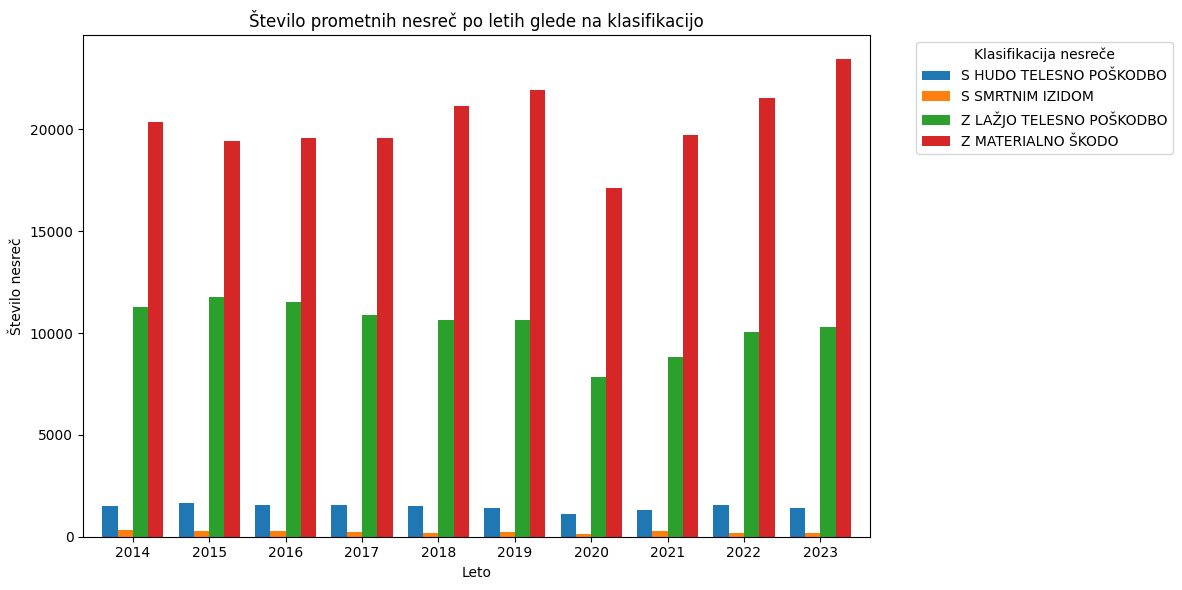

In [87]:
severity_by_year = data.groupby(["Year", "KlasifikacijaNesrece"]).size().unstack(fill_value=0)
severity_by_year = severity_by_year.sort_index()

severity_by_year.plot(
    kind='bar',
    stacked=False,
    figsize=(12, 6),
    width=0.8
)

plt.title("Število prometnih nesreč po letih glede na klasifikacijo")
plt.xlabel("Leto")
plt.ylabel("Število nesreč")
plt.legend(title="Klasifikacija nesreče", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

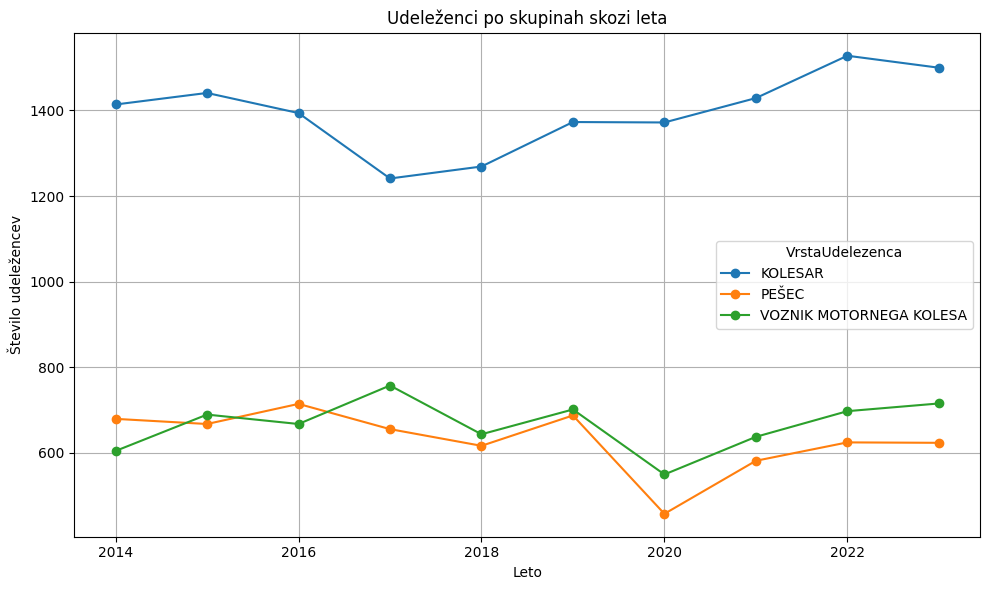

In [88]:
##SHIT

import matplotlib.pyplot as plt

ciljne_skupine = ["PEŠEC", "KOLESAR", "VOZNIK MOTORNEGA KOLESA"]

udelezenci_filtrirani = data[data["VrstaUdelezenca"].isin(ciljne_skupine)]

udelezenci_po_letih = (
    udelezenci_filtrirani
    .groupby(["Year", "VrstaUdelezenca"])
    .size()
    .unstack(fill_value=0)
)

udelezenci_po_letih.plot(kind="line", marker="o", figsize=(10, 6), title="Udeleženci po skupinah skozi leta")
plt.xlabel("Leto")
plt.ylabel("Število udeležencev")
plt.grid(True)
plt.tight_layout()
plt.show()


## Kolikšen delež povzročiteljev je imel pozitiven alkotest?

In [89]:
povzrocitelji = data[data["Povzrocitelj"] == "POVZROČITELJ"]

alko_raw = data["VrednostAlkotesta"].astype(str).str.replace(",", ".").str.strip()
alko = pd.to_numeric(alko_raw, errors="coerce").fillna(0)

pijani_povzrocitelji = povzrocitelji[alko.loc[povzrocitelji.index] > 0]
delež = len(pijani_povzrocitelji) / len(povzrocitelji)

print(f"Delež pijanih povzročiteljev: {delež:.2%}")


Delež pijanih povzročiteljev: 11.04%


## Histogram starosti povzročiteljev nesreč

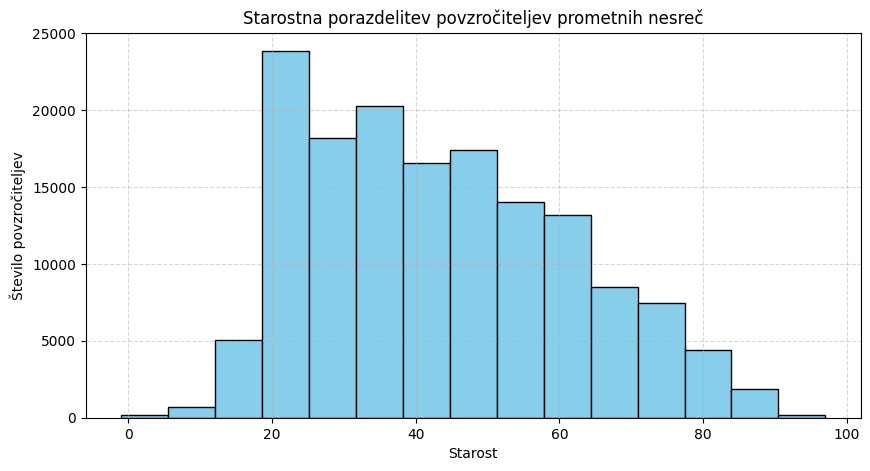

Povprečna starost povzročiteljev nesreč: 43.3 let


In [90]:
povzrocitelji = data[data["Povzrocitelj"] == "POVZROČITELJ"]

starosti = povzrocitelji["Starost"]

plt.figure(figsize=(10, 5))
plt.hist(starosti, bins=15, color="skyblue", edgecolor="black")
plt.title("Starostna porazdelitev povzročiteljev prometnih nesreč")
plt.xlabel("Starost")
plt.ylabel("Število povzročiteljev")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

povprecna_starost = starosti.mean()
print(f"Povprečna starost povzročiteljev nesreč: {povprecna_starost:.1f} let")



## Vizualizacija gručen udeležencev prometnih nesreč

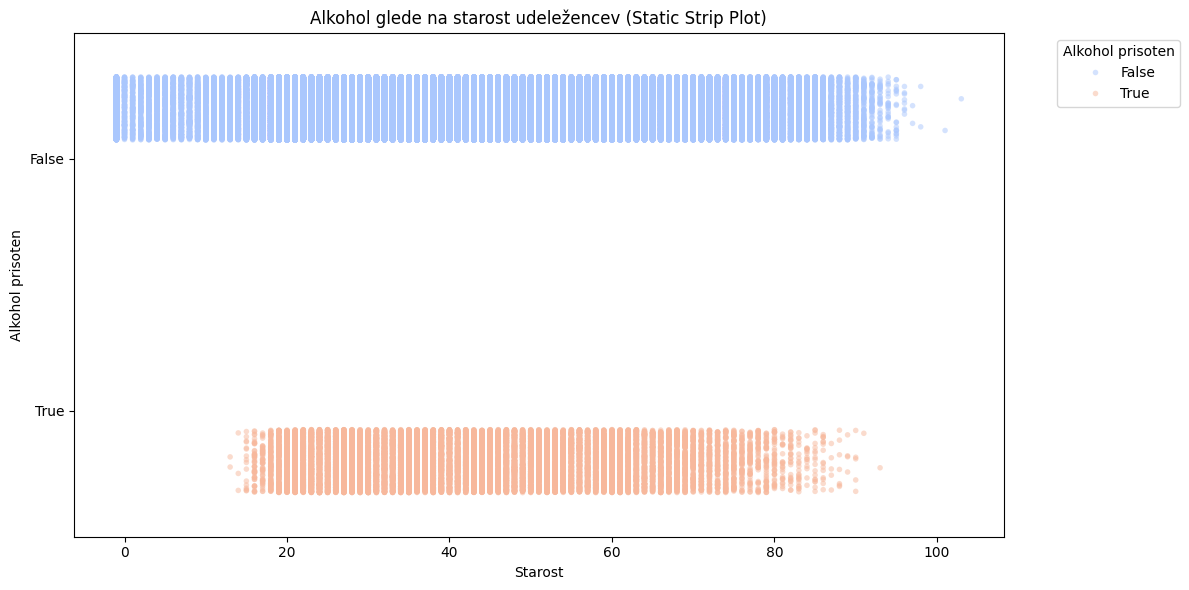

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.stripplot(
    data=data,
    x="Starost",
    y="AlkoholPrisoten",
    hue="AlkoholPrisoten",
    jitter=0.25,
    dodge=True,
    alpha=0.5,
    size=4,
    palette="coolwarm",
    orient="h"
)
plt.title("Alkohol glede na starost udeležencev (Static Strip Plot)")
plt.xlabel("Starost")
plt.ylabel("Alkohol prisoten")
plt.legend(title="Alkohol prisoten", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Porazdelitev nesreč glede na vreme

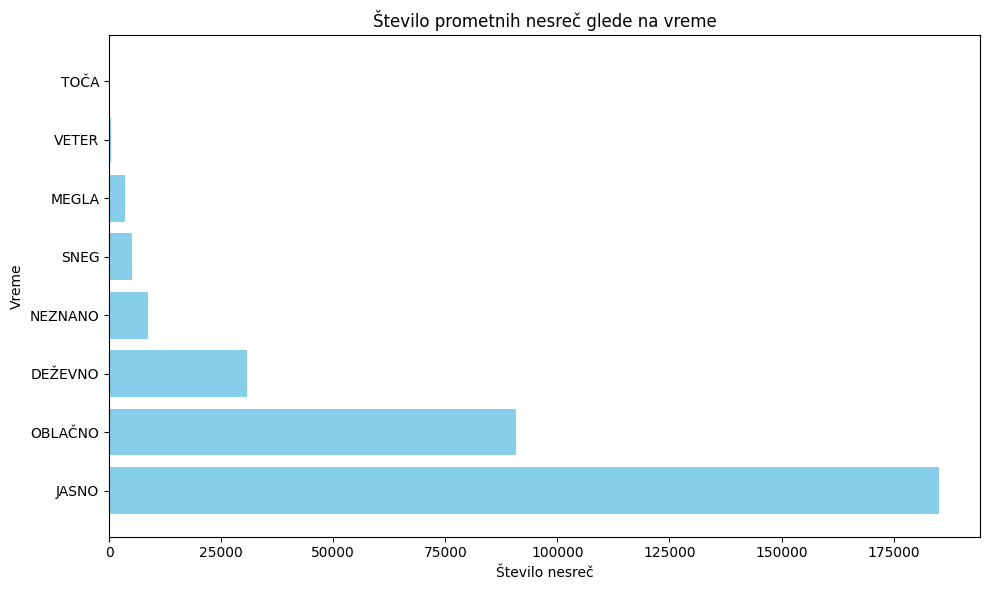

In [92]:
##SHIT

weather_counts = data['VremenskeOkoliscine'].value_counts()

plt.figure(figsize=(10, 6))
plt.barh(weather_counts.index, weather_counts.values, color='skyblue')
plt.title('Število prometnih nesreč glede na vreme')
plt.xlabel('Število nesreč')
plt.ylabel('Vreme')
plt.tight_layout()
plt.show()



## Vreme in vrsta trčenja (npr. BOČNO TRČENJE, NALETNO TRČENJE, …)

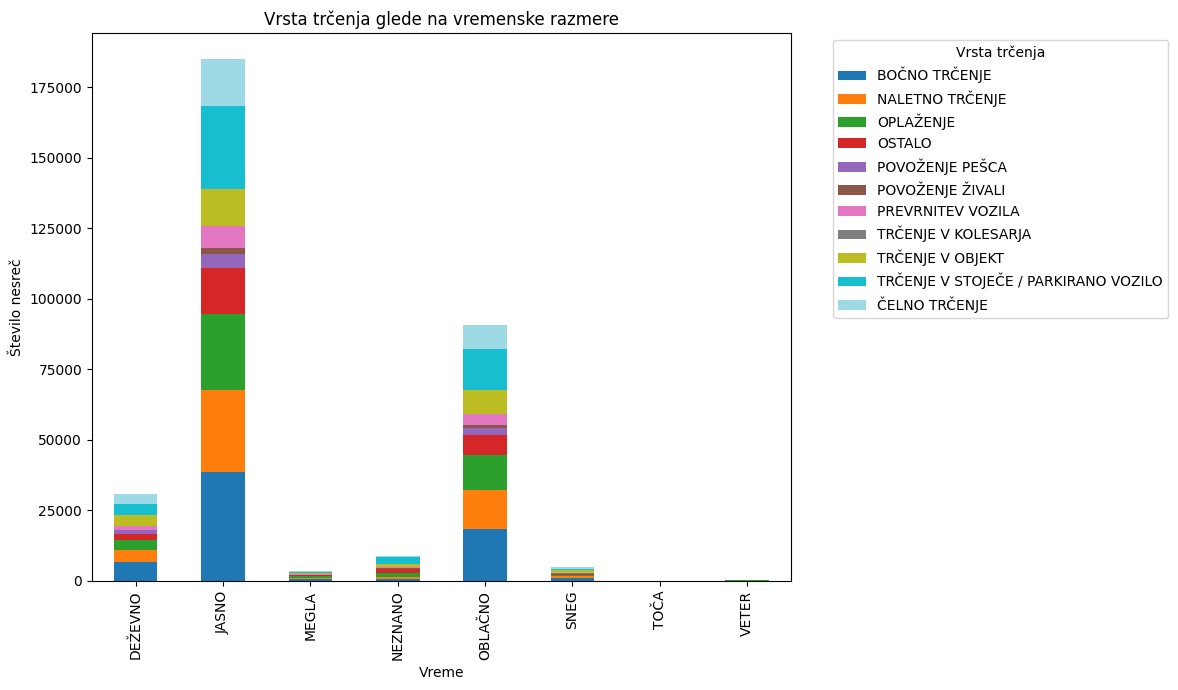

In [93]:
#SHIT

vrsta_trcenja_vreme = data.groupby(['VremenskeOkoliscine', 'TipNesrece']).size().unstack(fill_value=0)

vrsta_trcenja_vreme.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='tab20')
plt.title('Vrsta trčenja glede na vremenske razmere')
plt.xlabel('Vreme')
plt.ylabel('Število nesreč')
plt.legend(title='Vrsta trčenja', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Ali se v mokrem vremenu zgodi več nesreč zaradi neprilagojene hitrosti?

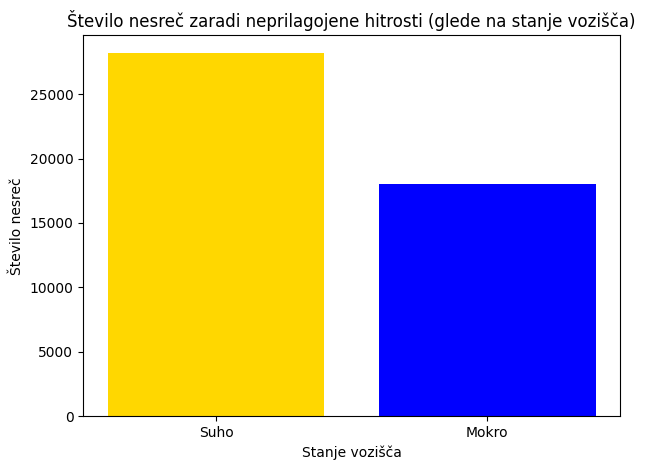

In [94]:
#SHIT

mokro_vreme = data[data['StanjeVozisca'].str.contains('MOKRO', na=False)]

neprilagojena_mokro = mokro_vreme['VzrokNesrece'].value_counts().get('NEPRILAGOJENA HITROST', 0)

suho_vreme = data[data['StanjeVozisca'].str.contains('SUHO', na=False)]
neprilagojena_suho = suho_vreme['VzrokNesrece'].value_counts().get('NEPRILAGOJENA HITROST', 0)

plt.bar(['Suho', 'Mokro'], [neprilagojena_suho, neprilagojena_mokro], color=['gold', 'blue'])
plt.title('Število nesreč zaradi neprilagojene hitrosti (glede na stanje vozišča)')
plt.xlabel('Stanje vozišča')
plt.ylabel('Število nesreč')
plt.tight_layout()
plt.show()


## Najmlajši povzročitelj nesreče

In [95]:
data_cleaned = data[data['Starost'].notna() & (data['Starost'] > 0)]

youngest_perpetrator = data_cleaned[data_cleaned['Povzrocitelj'] == 'POVZROČITELJ'].sort_values(by='Starost').iloc[0]

print("Najmlajši povzročitelj nesreče - Starost:")
print(youngest_perpetrator['Starost'])

print("\nDruge informacije o najmlajšem povzročitelju nesreče:")
print(youngest_perpetrator)


Najmlajši povzročitelj nesreče - Starost:
1

Druge informacije o najmlajšem povzročitelju nesreče:
ZaporednaStevilkaPN                                     3002
KlasifikacijaNesrece                Z LAŽJO TELESNO POŠKODBO
UpravnaEnotaStoritve                               LJUBLJANA
DatumPN                                           01.04.2021
UraPN                                                   9.15
VNaselju                                                  DA
Lokacija                                             NASELJE
VrstaCesteNaselja              NASELJE BREZ ULIČNEGA SISTEMA
SifraCesteNaselja                                      28127
TekstCesteNaselja                        PREVALJE POD KRIMOM
SifraOdsekaUlice                                           0
TekstOdsekaUlice                                  NI ODSEKOV
StacionazaDogodka                                         18
OpisKraja                                              CESTA
VzrokNesrece                             NEPRAV

## Najmlajši povzročitelj nesreče

In [96]:
oldest_perpetrator = data_cleaned[data_cleaned['Povzrocitelj'] == 'POVZROČITELJ'].sort_values(by='Starost', ascending=False).iloc[0]

print("Najstarejši povzročitelj nesreče - Starost:")
print(oldest_perpetrator['Starost'])

print("\nDruge informacije o najstarejšem povzročitelju nesreče:")
print(oldest_perpetrator)


Najstarejši povzročitelj nesreče - Starost:
97

Druge informacije o najstarejšem povzročitelju nesreče:
ZaporednaStevilkaPN                                 11235
KlasifikacijaNesrece             Z LAŽJO TELESNO POŠKODBO
UpravnaEnotaStoritve                               KAMNIK
DatumPN                                        18.08.2019
UraPN                                                11.4
VNaselju                                               NE
Lokacija                                            CESTA
VrstaCesteNaselja                        REGIONALNA CESTA
SifraCesteNaselja                                   00225
TekstCesteNaselja               MENGEŠ-DUPLICA-ŠENTRUPERT
SifraOdsekaUlice                                     1140
TekstOdsekaUlice                           MENGEŠ-DUPLICA
StacionazaDogodka                                    1940
OpisKraja                                        KRIŽIŠČE
VzrokNesrece                        NEPRILAGOJENA HITROST
TipNesrece                

In [97]:
gender_counts = data_cleaned[data_cleaned['Povzrocitelj'] == 'POVZROČITELJ']['Spol'].value_counts()

print("Spol, ki je najpogostejši krivec za prometne nesreče:")
print(gender_counts)


Spol, ki je najpogostejši krivec za prometne nesreče:
Spol
MOŠKI     110862
ŽENSKI     40782
NEZNAN         1
Name: count, dtype: int64


In [98]:
alcohol_status = data_cleaned[data_cleaned['Povzrocitelj'] == 'POVZROČITELJ'].groupby(['Spol', 'AlkoholPrisoten']).size().unstack(fill_value=0)

print("Analiza stanja glede na spol in alkohol:")
print(alcohol_status)

trezni_zenske = alcohol_status.loc['Ž', 0]  
trezni_moski = alcohol_status.loc['M', 0] 

if trezni_zenske > trezni_moski:
    print("\nVeč treznih žensk je povzročilo nesrečo kot treznih moških.")
else:
    print("\nVeč treznih moških je povzročilo nesrečo kot treznih žensk.")


Analiza stanja glede na spol in alkohol:
AlkoholPrisoten  False  True 
Spol                         
MOŠKI            96074  14788
NEZNAN               1      0
ŽENSKI           38817   1965


KeyError: 0

##  Koliko od moških in žensk je bilo Slovencev in koliko tujcev

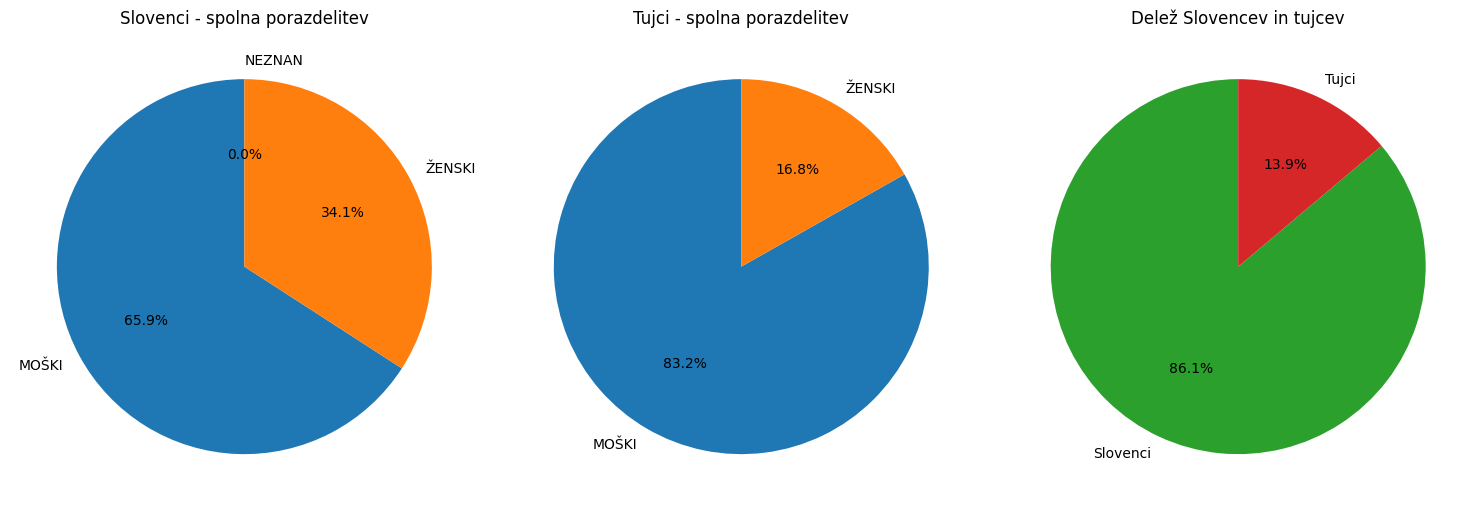

In [ ]:
slovenci = data_cleaned[data_cleaned['Drzavljanstvo'] == 'SLOVENIJA']
tujci = data_cleaned[data_cleaned['Drzavljanstvo'] != 'SLOVENIJA']

slovenci_spol = slovenci['Spol'].value_counts()
tujci_spol = tujci['Spol'].value_counts()

#print("Število Slovencev in tujcev glede na spol:")
#print("Slovenci:")
#print(slovenci_spol)
#print("\nTujci:")
#print(tujci_spol)

total_slovenci = slovenci.shape[0]
total_tujci = tujci.shape[0]

total = total_slovenci + total_tujci
percentage_slovenci = (total_slovenci / total) * 100 if total > 0 else 0
percentage_tujci = (total_tujci / total) * 100 if total > 0 else 0

#print("\nOdstotek Slovencev in tujcev med povzročitelji nesreč:")
#print(f"Slovenci: {percentage_slovenci:.2f}%")
#print(f"Tujci: {percentage_tujci:.2f}%")


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.pie(slovenci_spol, labels=slovenci_spol.index, autopct='%1.1f%%', startangle=90, colors=['#1f77b4', '#ff7f0e'])
plt.title('Slovenci - spolna porazdelitev')

plt.subplot(1, 3, 2)
plt.pie(tujci_spol, labels=tujci_spol.index, autopct='%1.1f%%', startangle=90, colors=['#1f77b4', '#ff7f0e'])
plt.title('Tujci - spolna porazdelitev')

plt.subplot(1, 3, 3)
plt.pie([total_slovenci, total_tujci],
        labels=['Slovenci', 'Tujci'],
        autopct='%1.1f%%',
        startangle=90,
        colors=['#2ca02c', '#d62728'])
plt.title('Delež Slovencev in tujcev')

plt.tight_layout()
plt.show()

KOLIKO NESREČ SO POVZROČILI TUJI VOZNIKI (VOZNIKI KI NISO IZ SLOVENIJE)

In [ ]:
povzrocitelji = data[data["Povzrocitelj"] == "POVZROČITELJ"].copy()

povzrocitelji["Tujec"] = povzrocitelji["Drzavljanstvo"].str.upper() != "SLOVENIJA"

unikatne_nesrece = povzrocitelji.drop_duplicates(subset="ZaporednaStevilkaPN")

skupno = len(unikatne_nesrece)
tuje = unikatne_nesrece["Tujec"].sum()

print(f"Skupno št. nesreč s povzročiteljem: {skupno}")
print(f"Št. nesreč s tujim povzročiteljem: {tuje}")
print(f"Delež tujih povzročiteljev: {tuje / skupno * 100:.2f}%")

Skupno št. nesreč s povzročiteljem: 19620
Št. nesreč s tujim povzročiteljem: 2345
Delež tujih povzročiteljev: 11.95%


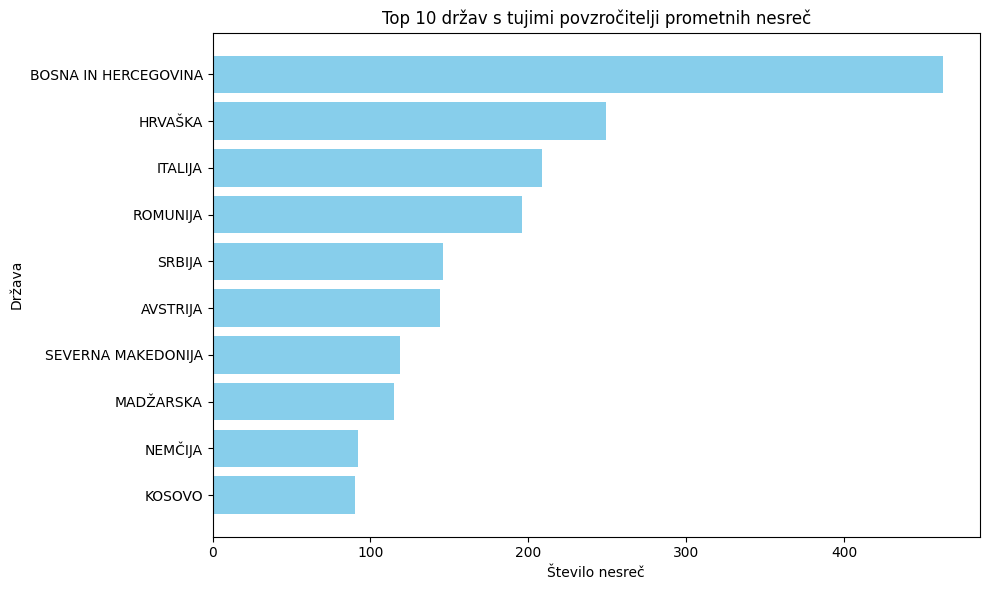

In [ ]:
tuji_povzrocitelji = unikatne_nesrece[unikatne_nesrece["Tujec"] == True]

drzave_top = tuji_povzrocitelji["Drzavljanstvo"].value_counts().head(10)

#print("Top 10 držav s povzročitelji nesreč (tujci):")
#print(drzave_top)


#GRAF

drzave_top = tuji_povzrocitelji["Drzavljanstvo"].value_counts().head(10)

plt.figure(figsize=(10, 6))
plt.barh(drzave_top.index, drzave_top.values, color='skyblue')
plt.xlabel("Število nesreč")
plt.ylabel("Država")
plt.title("Top 10 držav s tujimi povzročitelji prometnih nesreč")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
